# Artificial Neural Networks and Deep 

## Ex02 - Non-Linearity in Higher Dimensions

In [5]:
import numpy as np

In [6]:
# Parametros da funcao:
meanA = [0,0,0,0,0]
covA = np.array([
    [1.0, 0.8, 0.1, 0.0, 0.0],
    [0.8, 1.0, 0.3, 0.0, 0.0],
    [0.1, 0.3, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.2],
    [0.0, 0.0, 0.0, 0.2, 1.0]
])

meanB = [1.5, 1.5, 1.5, 1.5, 1.5]
covB = np.array([
    [1.5, -0.7, 0.2, 0.0, 0.0],
    [-0.7, 1.5, 0.4, 0.0, 0.0],
    [0.2, 0.4, 1.5, 0.6, 0.0],
    [0.0, 0.0, 0.6, 1.5, 0.3],
    [0.0, 0.0, 0.0, 0.3, 1.5]
])

dataA = np.random.multivariate_normal(meanA,covA,500)
dataB = np.random.multivariate_normal(meanB,covB,500)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = np.vstack([dataA, dataB])
y = np.array(['A']*len(dataA) + ['B']*len(dataB))

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
Z = pca.fit_transform(X_std)


Explained variance ratio (PC1, PC2): [0.52017441 0.15376346]
Total 2D variance explained: 0.6739378707782059


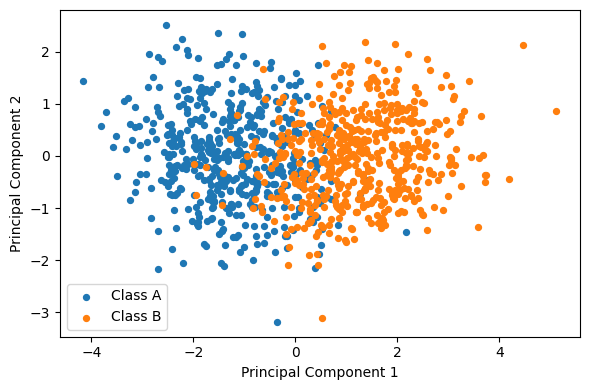

In [7]:
# ---- a partir do seu código (dataA, dataB já criados) ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) empilha as duas classes e cria os rótulos
X = np.vstack([dataA, dataB])            # shape (1000, 5)
y = np.array(['A']*len(dataA) + ['B']*len(dataB))

# 2) padroniza (média 0, desvio 1) antes do PCA
X_std = StandardScaler().fit_transform(X)

# 3) PCA para 2 componentes
pca = PCA(n_components=2)
Z = pca.fit_transform(X_std)             # shape (1000, 2)

# opcional: quanta variância PC1+PC2 explicam?
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total 2D variance explained:", pca.explained_variance_ratio_.sum())

# 4) scatter 2D colorindo por classe
plt.figure(figsize=(6,4))
for lab, col in zip(('A','B'), ('tab:blue','tab:orange')):
    idx = (y == lab)
    plt.scatter(Z[idx, 0], Z[idx, 1], s=18, label=f'Class {lab}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.show()


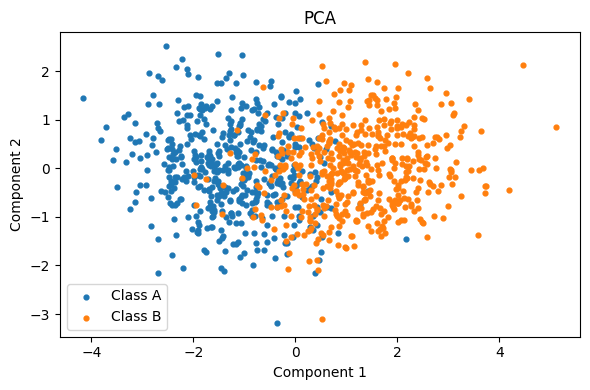

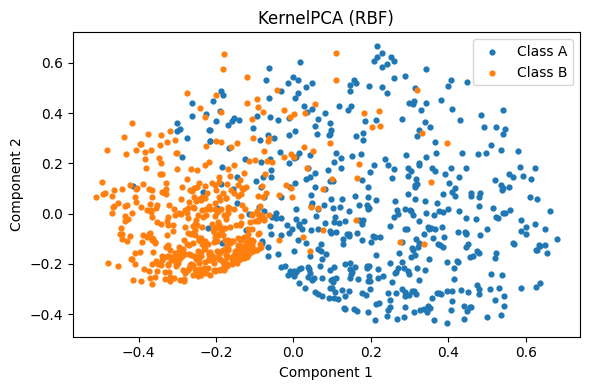

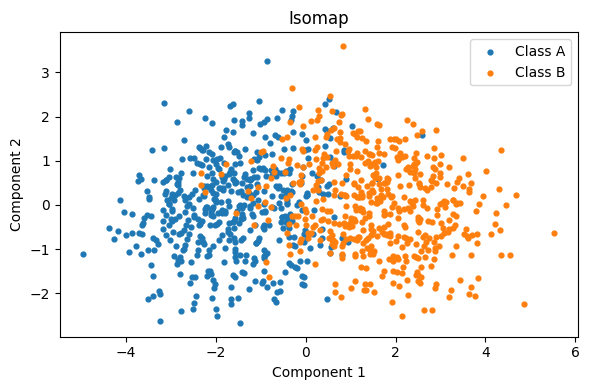

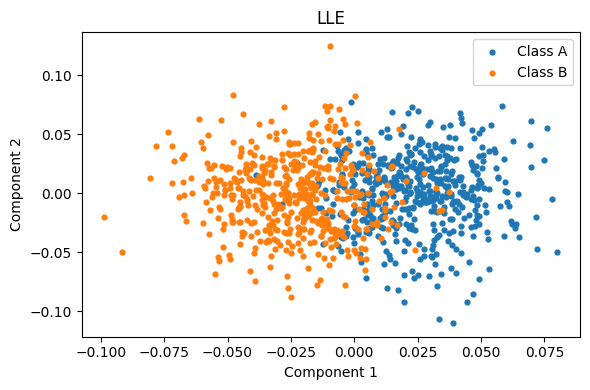

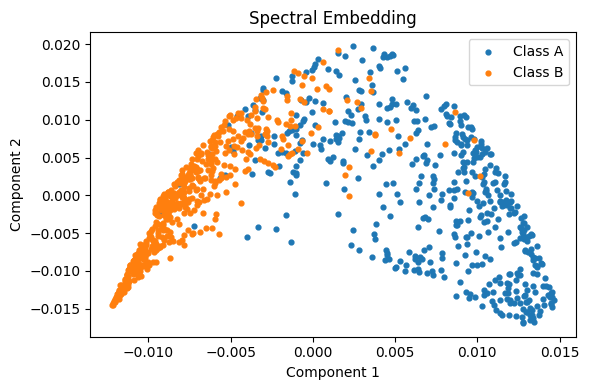

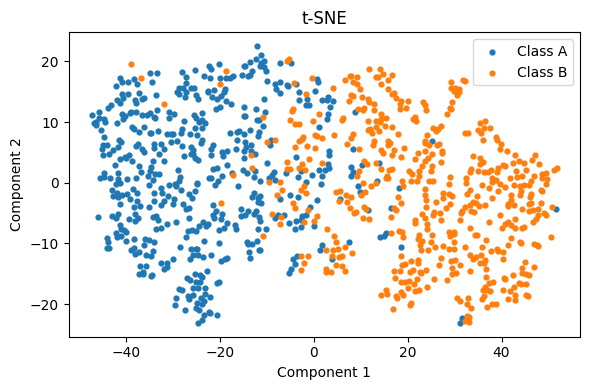


=== Dimensionality Reduction: Comparison Metrics ===
            Method  Trustworthiness@12  Silhouette  kNN(5) CV Acc  Fisher Ratio  Explained Var (2D)
             t-SNE            0.977410    0.461134          0.920      2.826775                 NaN
Spectral Embedding            0.851930    0.352003          0.902      1.062955                 NaN
   KernelPCA (RBF)            0.787827    0.325156          0.892      1.043269                 NaN
               LLE            0.856462    0.274128          0.875      0.839438                 NaN
               PCA            0.864511    0.362713          0.863      1.696896            0.673938
            Isomap            0.868698    0.382801          0.858      1.876618                 NaN


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import silhouette_score

try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False
    def trustworthiness(*args, **kwargs):
        return np.nan

X = np.vstack([dataA, dataB])                 # (1000, 5)
y = np.array(['A']*len(dataA) + ['B']*len(dataB))  # (1000,)

# Padronização (média 0, desvio 1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# -----------------------------
# 2) Definir métodos (6 no total)
# -----------------------------
methods = {}

# 1) PCA (baseline linear)
methods['PCA'] = PCA(n_components=2)

# 2) Kernel PCA (RBF) para capturar não-linearidade
methods['KernelPCA (RBF)'] = KernelPCA(
    n_components=2, kernel='rbf', gamma=0.5, fit_inverse_transform=False
)

# 3) Isomap (distâncias geodésicas no grafo de vizinhos)
methods['Isomap'] = Isomap(n_components=2, n_neighbors=15)

# 4) LLE (Local Linear Embedding)
methods['LLE'] = LocallyLinearEmbedding(
    n_neighbors=15, n_components=2, method='standard'
)

# 5) Spectral Embedding (Laplacian Eigenmaps)
methods['Spectral Embedding'] = SpectralEmbedding(
    n_components=2, n_neighbors=15, random_state=42
)

# 6) t-SNE (boa separação local para visualização)
methods['t-SNE'] = TSNE(
    n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42
)

# -----------------------------
# 3) Funções auxiliares
# -----------------------------
def run_embedding(model, X_input):
    """Aplica fit_transform quando existir; senão fit + transform."""
    if hasattr(model, 'fit_transform'):
        Z = model.fit_transform(X_input)
    else:
        model.fit(X_input)
        Z = model.transform(X_input)
    return Z

def plot_embedding(Z, title, y):
    """Scatter 2D com as duas classes (sem definir cores explicitamente)."""
    plt.figure(figsize=(6, 4))
    idxA = (y == 'A')
    idxB = ~idxA
    plt.scatter(Z[idxA, 0], Z[idxA, 1], s=12, label='Class A')
    plt.scatter(Z[idxB, 0], Z[idxB, 1], s=12, label='Class B')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fisher_separation(Z, y):
    """
    Medida simples tipo Fisher para 2 classes:
    ||muA - muB||^2 / trace(Sw),
    onde Sw = cov(ZA) + cov(ZB)
    """
    ZA = Z[y == 'A']
    ZB = Z[y == 'B']
    muA = ZA.mean(axis=0)
    muB = ZB.mean(axis=0)
    Sw = np.cov(ZA, rowvar=False) + np.cov(ZB, rowvar=False)
    num = np.sum((muA - muB)**2)
    den = np.trace(Sw)
    return float(num / den) if den > 0 else np.nan

def knn_cv_accuracy(Z, y, n_splits=5, n_neighbors=5):
    """Acurácia média 5-fold CV de um k-NN (k=5) no embedding 2D."""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(clf, Z, y, cv=cv, scoring='accuracy')
    return float(scores.mean())

# -----------------------------
# 4) Rodar métodos + coletar métricas
# -----------------------------
rows = []

if not HAS_TRUST:
    print("[aviso] sklearn.manifold.trustworthiness não disponível nesta versão; métricas 'Trustworthiness' serão NaN.\n")

for name, model in methods.items():
    Z = run_embedding(model, X_std)

    # Plota (figura separada por método)
    plot_embedding(Z, f'{name}', y)

    # Métricas
    tw = trustworthiness(X_std, Z, n_neighbors=12)
    sil = silhouette_score(Z, y)        # separação das classes no 2D
    acc = knn_cv_accuracy(Z, y, n_splits=5, n_neighbors=5)
    fish = fisher_separation(Z, y)

    # PCA: variância explicada em 2D
    if name == 'PCA':
        pca_var2d = float(np.sum(methods['PCA'].explained_variance_ratio_))
    else:
        pca_var2d = np.nan

    rows.append({
        'Method': name,
        'Trustworthiness@12': tw,
        'Silhouette': sil,
        'kNN(5) CV Acc': acc,
        'Fisher Ratio': fish,
        'Explained Var (2D)': pca_var2d
    })

# -----------------------------
# 5) Mostrar tabela de métricas
# -----------------------------
df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics.sort_values(
    by=['kNN(5) CV Acc', 'Silhouette', 'Trustworthiness@12'],
    ascending=False
).reset_index(drop=True)

print("\n=== Dimensionality Reduction: Comparison Metrics ===")
print(df_metrics.to_string(index=False))

1) O que os gráficos mostram sobre a relação entre as classes

PCA (linear, variância global)

As duas classes se deslocam principalmente ao longo do 1º componente (PC1).

Há sobreposição considerável na região central: as “caudas” elípticas dos dois grupos se interpenetram.

Leitura: existe um shift de média entre A e B (esperado, pois µ_B = 1.5 em todas as dimensões), mas as covariâncias diferentes (orientações/formatos dos elipsóides) fazem os pontos “misturarem” quando projetados em 2D.

Kernel PCA (RBF)

Aparece um fronteira curva (formato “banana”) entre os grupos.

O método está captando estruturas não‑lineares que o PCA linear não mostra. A separação melhora em relação ao PCA, mas ainda há zona de transição.

Isomap

Projeção lembra o PCA (classes separadas grosso modo ao longo de um eixo), mas com distorções que alongam a nuvem.

Ainda existe faixa de sobreposição: um único hiperplano não separa perfeitamente.

LLE

Resultado muito parecido com o PCA: tendência linear + mistura no meio.

Indica que a estrutura local não oferece uma divisão limpa sem curvatura adicional.

Spectral Embedding

Surge uma estrutura em arco/horseshoe. As classes ocupam metades do arco, com bordas que se entremeiam.

A fronteira é claramente não‑linear.

t‑SNE

Dois aglomerados bem separados no plano 2D; quase não há mistura visual.

Cuidado: t‑SNE preserva vizinhanças locais, mas não preserva distâncias/forma globais. Essa separação “bonita” não garante que exista um corte linear no espaço original; ela mostra, porém, que localmente as vizinhanças de A e B são diferentes.

Resumo da relação entre as classes:

Há um deslocamento de média entre A e B + diferenças de correlação/orientação (covariâncias distintas).

Em projeções lineares (PCA/LLE/Isomap) a separação é parcial; em projeções não‑lineares (KernelPCA, Spectral, t‑SNE) aparece uma borda curva e a separação melhora.

2) As classes são linearmente separáveis?

Não perfeitamente.

Nos métodos lineares (PCA, LLE) há uma faixa de interpenetração clara.

Mesmo quando a visualização sugere separação (t‑SNE), isso não implica uma hiperplano no 5D original.

Por que isso acontece aqui?

As matrizes de covariância não são iguais: 
Σ
𝐴
≠
Σ
𝐵
Σ
A
	​


=Σ
B
	​

.

Para duas gaussianas com covariâncias iguais, a fronteira ótima (via razão de verossimilhança) é linear (caso LDA).

Quando as covariâncias diferem, a fronteira Bayes ótima vira quadrática (caso QDA) — não linear.

É exatamente o seu cenário: A tem correlações fortes (e.g., 0.8 entre 
𝑥
1
,
𝑥
2
x
1
	​

,x
2
	​

, 0.5 entre 
𝑥
3
,
𝑥
4
x
3
	​

,x
4
	​

), B tem outras correlações (e.g., ‑0.7 entre 
𝑥
1
,
𝑥
2
x
1
	​

,x
2
	​

, 0.6 entre 
𝑥
3
,
𝑥
4
x
3
	​

,x
4
	​

). Esses “giros/alongamentos” elípticos diferentes fazem as nuvens se cruzarem; um hiperplano não consegue separar sem erro.

3) Por que modelos lineares simples sofrem — e por que redes com não‑linearidades ajudam

Modelos lineares (Perceptron, Regressão Logística sem features não‑lineares) só implementam uma única fronteira plana.

Como as classes aqui precisam de uma fronteira curvada (quadrática ou mais complexa) para reduzir a faixa de sobreposição, um hiperplano vai sempre cortar a zona mista e errar bastante.

Modelos com não‑linearidade (multi‑layer perceptron com ReLU/tanh, kernel methods, QDA, SVM com kernel RBF) conseguem “entortar” o espaço ou compor curvas para aproximar a fronteira Bayesiana.

A evidência visual: Kernel PCA, Spectral e t‑SNE revelam uma separação curvada/manifold‑like, sugerindo que duas ou mais regiões precisam ser recortadas por uma função não‑linear para dividir A e B com boa acurácia.

4) Como eu justificaria no relatório (em 4 frases)

As projeções mostram que A e B diferem principalmente ao longo de um eixo global (PC1), mas se sobrepõem de forma relevante.

Métodos não‑lineares (KernelPCA, Spectral, t‑SNE) revelam fronteiras curvas e melhor separação local, o que não aparece na projeção linear.

Como 
Σ
𝐴
≠
Σ
𝐵
Σ
A
	​


=Σ
B
	​

, a fronteira ótima entre as distribuições gaussianas é quadrática, logo não linear; um hiperplano não separa bem.

Portanto, modelos lineares tendem a ter erro alto, enquanto modelos com não‑linearidades (ex.: MLP com tanh/ReLU, SVM RBF ou QDA) são mais adequados para capturar a geometria curvada do problema.

Se quiser, posso olhar as métricas que você imprimiu (silhouette, kNN‑acc, trustworthiness) e escrever duas linhas conectando cada método aos números que você obteve — isso deixa sua análise redonda.